In [1]:
import sys, os
sys.path.append(os.path.abspath('../'))
sys.path.append(os.path.abspath('../modules/'))
from modules.settings import global_mmf_settings as gset
from wrapper_scripts import evaluate_Y_M_scaling_reln_cosmo_cat as ymsr
from modules.settings import global_mmf_settings as gset
from cosmology import cosmo_fn
import multiprocessing as mp
from scipy.optimize import curve_fit
import bces.bces as bces
import time
from astropy.io import fits

%pylab notebook

Populating the interactive namespace from numpy and matplotlib


In [2]:
whichch="hfi"
dataset="planck_pr3"

if whichch=="allch":
    chmin=30.
elif whichch=="hfi":
    chmin=100.
    
figstamp=dataset + "_" + whichch

save_results=False
run_analysis=False

# Initialize MMF analysis

In [3]:
outpath="/results/" + dataset + "/planck_cosmo_cat_" + whichch + "/"
tempdatapath="/tempdata/" + dataset + "/planck_cosmo_cat/"
gset.setup_mmf_config(dataset=dataset,outpath=outpath,tempdatapath=tempdatapath,chmin=chmin,xsize=10.,do_band_pass=True)
figpath=gset.mmfset.paths["result_figs"]
pmmf=ymsr.Y_M_scaling() ; xsz_cat=pmmf.xsz_cat

ysz_cat=ymsr.ppd.get_cosmo_catalogue_ysz()
xsz_cat["BIAS"]=np.copy(ysz_cat["BIAS"])
xsz_cat["T500"]=np.copy(xsz_cat["TX"])
xsz_cat["M500"]=np.copy(ysz_cat["M_Yx_500"]/1e14)
xsz_cat["M500_err"]=(ysz_cat['ERRM_M_Yx_500'] + ysz_cat['ERRP_M_Yx_500'])*0.5/1e14
xsz_cat["YSZ_500"]=np.copy(ysz_cat['Y_500'])
xsz_cat["YSZ_500_err"]=np.copy(ysz_cat["ERR_Y_500"])

fxsz_cat={}
anatype=["x","xi","b"]
clr=["r","g","b"]
labels={}
labels["x"]="X-ray prior"
labels["xi"]="X-ray prior iterative"
labels["b"]="Blind"

def wrap_eval_Y500_xray_prior(idx):
    result=pmmf.eval_Y500_xray_prior(idx)
    return result

def parallel_eval_Y500_xray_prior(numprocs):
    pool=mp.Pool(processes=numprocs)
    result=pool.map(wrap_eval_Y500_xray_prior,pmmf.idx_list)
    pool.close()
    pool.join()
    return np.array(result)

def wrap_eval_Y500_xray_prior_iterative(idx):
    result=pmmf.eval_Y500_xray_prior_iterative(idx)
    return result

def parallel_eval_Y500_xray_prior_iterative(numprocs):
    pool=mp.Pool(processes=numprocs)
    result=pool.map(wrap_eval_Y500_xray_prior_iterative,pmmf.idx_list)
    pool.close()
    pool.join()
    return np.array(result)

def wrap_eval_Y500_blind(idx):
    result=pmmf.eval_Y500_blind(idx)
    return result

def parallel_eval_Y500_blind(numprocs):
    pool=mp.Pool(processes=numprocs)
    result=pool.map(wrap_eval_Y500_blind,pmmf.idx_list)
    pool.close()
    pool.join()
    return np.array(result)

# Extract data tangent planes

In [4]:
# ymsr.ppd.extract_tangent_planes()

In [5]:
def parallel_psfill(numprocs):
    pool=mp.Pool(processes=numprocs)
    pool.map(ymsr.ppd.gen_ps_inpainted_data,pmmf.idx_list)
    pool.close()
    pool.join()

In [13]:
from astropy.io import fits
filename=xsz_cat["FILENAME"][2]
f1=fits.open(filename)
f1.info()
fdata=f1[5].data
data=f1[2].data
mask=f1[3].data

Filename: /Users/adityarotti/Documents/Work/Projects/Relativistic-SZ/MMF-filters-for-rSZ-cluster-detection/Planck_MMF//tempdata/planck_pr3/planck_cosmo_cat/10deg_patches//tangent_planes/cluster_G49.22+30.86.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  Channels      1 ImageHDU         7   (9,)   float64   
  2  Data tangent plane    1 ImageHDU        13   (349, 349, 9)   float64   
  3  Point Source Mask    1 ImageHDU         8   (349, 349)   float64   
  4  Extended point Source Mask    1 ImageHDU         8   (349, 349)   float64   
  5  PSF Data tangent plane    1 ImageHDU         9   (349, 349, 9)   float64   


<IPython.core.display.Javascript object>


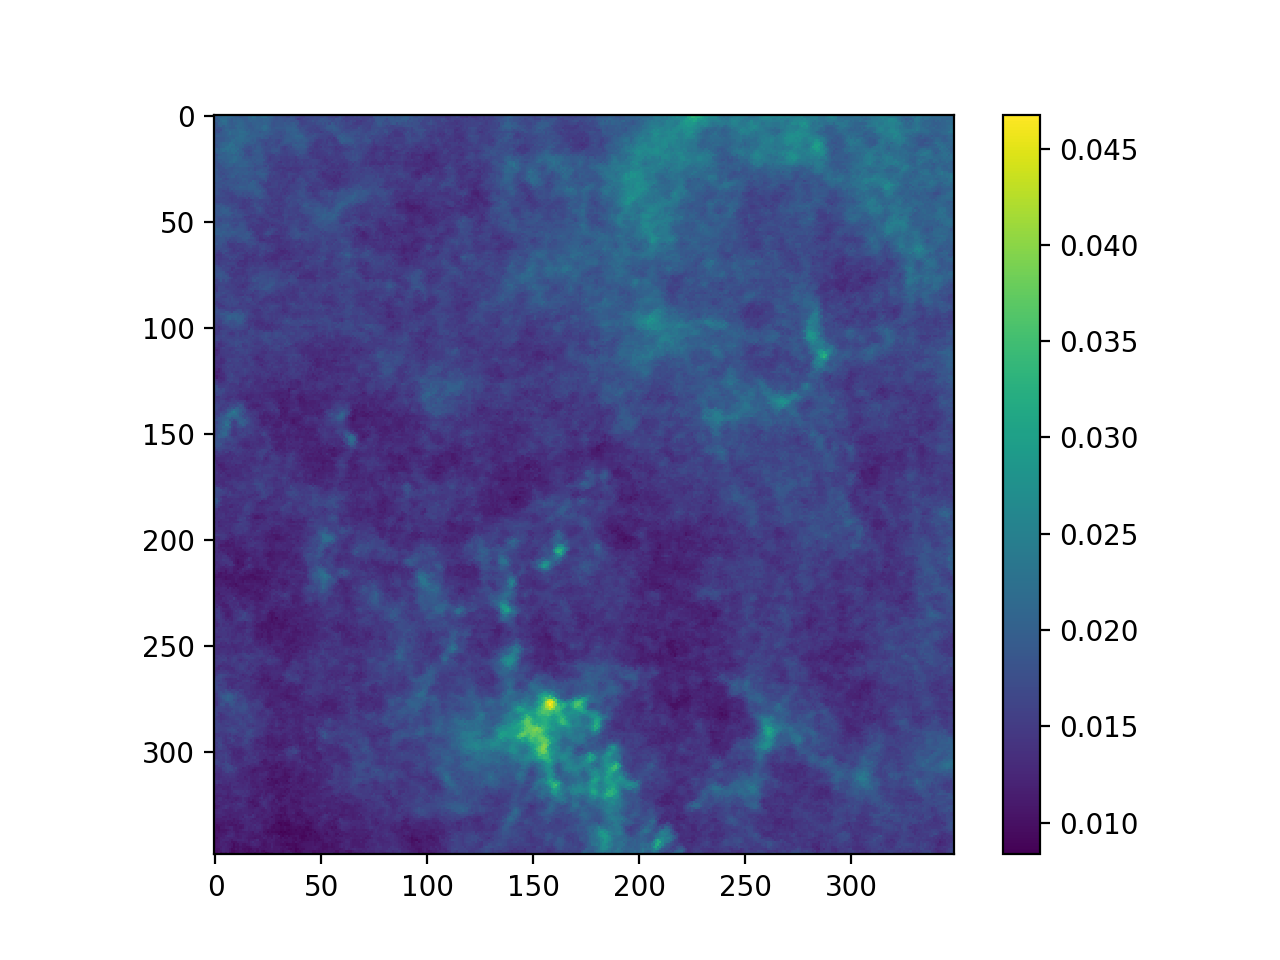

<IPython.core.display.Javascript object>

In [15]:
figure()
imshow(fdata[7,])
colorbar()

figure()
imshow(data[7,]*mask)
colorbar()

# Testing iterative scheme

In [23]:
idx=60

pmmf.emask=ymsr.gm.return_edge_apodized_mask(15.,20.)
fdata,err,fdatar=pmmf.return_cluster_catalogue(idx)
print max((fdata*pmmf.cmask).ravel()),err

figure()
imshow(fdata-fdatar)
colorbar()

IOError: [Errno 2] No such file or directory: '/Users/adityarotti/Documents/Work/Projects/Relativistic-SZ/MMF-filters-for-rSZ-cluster-detection/Planck_MMF//tempdata/planck_pr3/planck_cosmo_cat/10deg_patches//tangent_planes/cluster_G340.38+60.59.fits'

# MMF analysis with X-ray prior on location, size and temperature of cluster

In [4]:
# pmmf.emask[:,:]=1.
# start=time.time()
# result=parallel_eval_Y500_xray_prior(8)
# print time.time()-start

# filename="ysz_cat_xrayprior_no_edge_mask.fits"
# fxsz_cat=ymsr.write_catalogue(result,filename=filename)

if run_analysis:
    pmmf.emask[:,:]=ymsr.gm.return_edge_apodized_mask(15.,20.)
    start=time.time()
    result=parallel_eval_Y500_xray_prior(32)
    print time.time()-start

    filename="ysz_cat_xrayprior_apo_edge_mask.fits"
    fxsz_cat["x"]=ymsr.write_catalogue(result,filename=filename)
else:
    filename="ysz_cat_xrayprior_apo_edge_mask.fits"
    fxsz_cat["x"]=ymsr.read_catalogue(filename=filename)

# MMF analysis with X-ray prior on location, size and temperature of cluster - iterative noise estimation

In [5]:
if run_analysis:
    start=time.time()
    pmmf.emask[:,:]=ymsr.gm.return_edge_apodized_mask(15.,20.)
    result=parallel_eval_Y500_xray_prior_iterative(32)
    print time.time()-start

    filename="ysz_cat_xrayprior_iterative_apo_edge_mask.fits"
    fxsz_cat["xi"]=ymsr.write_catalogue(result,filename)
else:
    filename="ysz_cat_xrayprior_iterative_apo_edge_mask.fits"
    fxsz_cat["xi"]=ymsr.read_catalogue(filename=filename)

# Blind MMF analysis

In [6]:
if run_analysis:
    start=time.time()
    pmmf.emask[:,:]=ymsr.gm.return_edge_apodized_mask(15.,20.)
    result=parallel_eval_Y500_blind(32)
    print time.time()-start

    filename="ysz_cat_blind_apo_edge_mask.fits"
    fxsz_cat["b"]=ymsr.write_catalogue(result,filename=filename)
else:
    filename="ysz_cat_blind_apo_edge_mask.fits"
    fxsz_cat["b"]=ymsr.read_catalogue(filename=filename)

# Results

## Figures for null tests

<IPython.core.display.Javascript object>


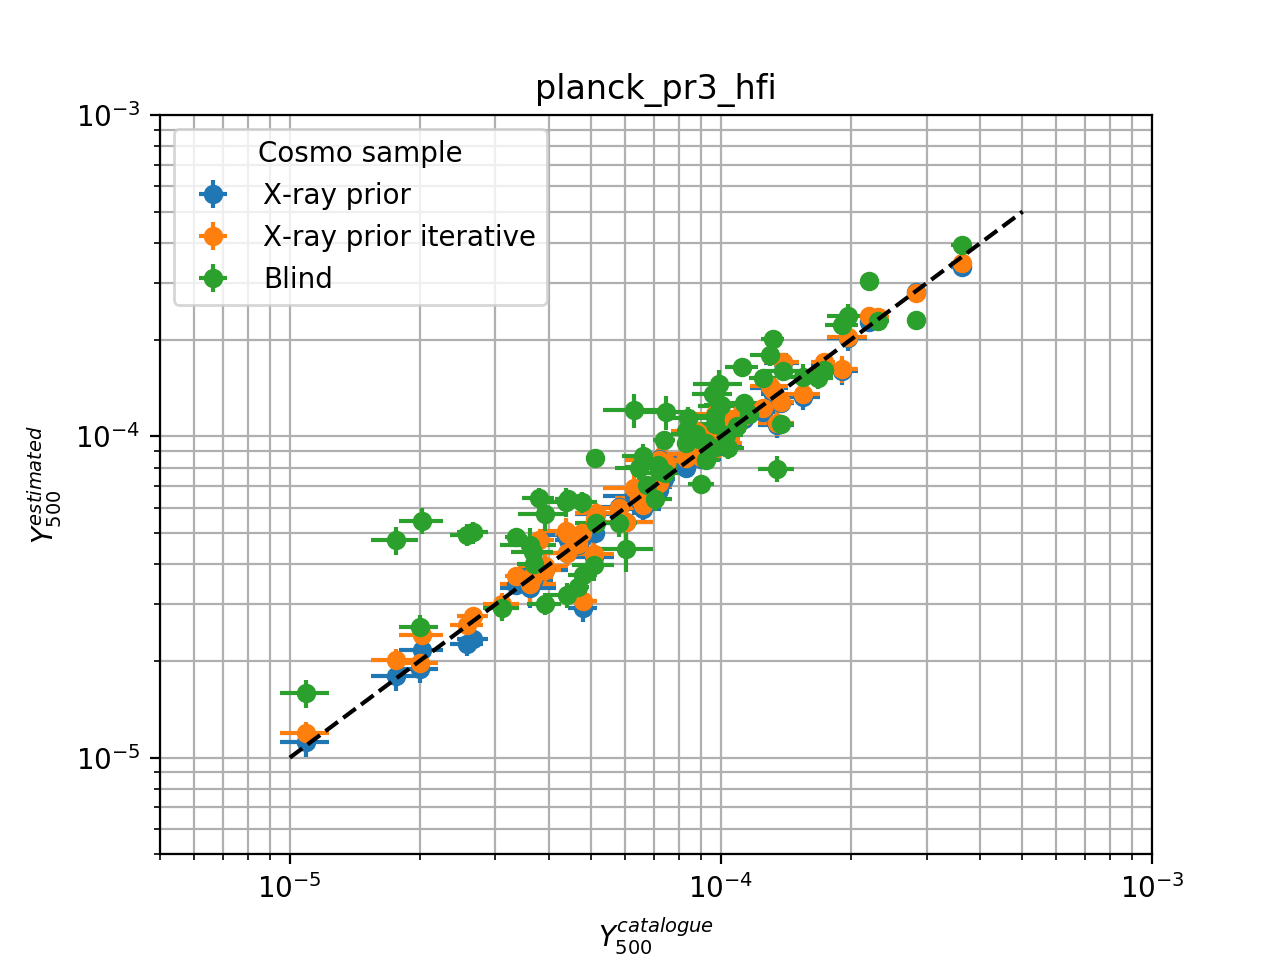

In [7]:
x=logspace(-5,-3.3,100)
figure()
for atype in anatype:
    lbl=labels[atype]
    errorbar(xsz_cat["YSZ_500"],fxsz_cat[atype]["YSZ_500"],xerr=xsz_cat["YSZ_500_err"],yerr=fxsz_cat[atype]["YSZ_500_err"],fmt="o",label=lbl)

plot(x,x,"k--",zorder=10)
grid(which="both")
xlabel("$Y^{catalogue}_{500}$",fontsize=10)
ylabel("$Y^{estimated}_{500}$",fontsize=10)
loglog()
ylim(5e-6,1e-3)
xlim(5e-6,1e-3)
legend(loc=0,title="Cosmo sample")
title(figstamp)
if save_results:
    figname=figpath + "compare_Y500.pdf"
    savefig(figname,bbox_inches="tight")

<IPython.core.display.Javascript object>


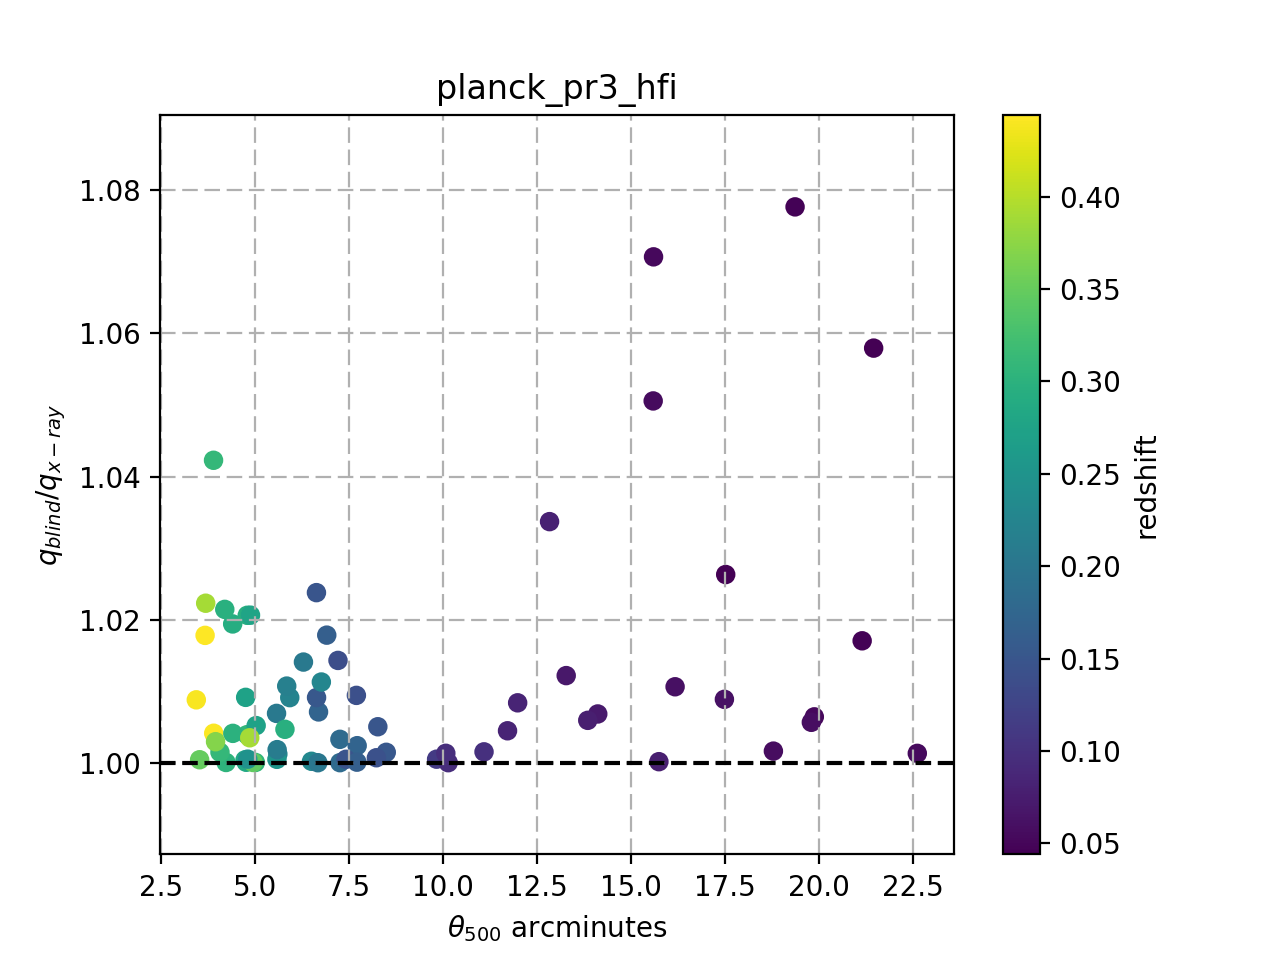

In [8]:
figure()
qcat=xsz_cat["YSZ_500"]/xsz_cat["YSZ_500_err"]
qblind=fxsz_cat["b"]["YSZ_500"]/fxsz_cat["b"]["YSZ_500_err"]
qx=fxsz_cat["x"]["YSZ_500"]/fxsz_cat["x"]["YSZ_500_err"]

scatter(xsz_cat["theta500"],qblind/qx,c=xsz_cat["z"])
colorbar(label="redshift")
ylabel(r"$q_{blind} / q_{x-ray}$")
xlabel(r"$\theta_{500}$ arcminutes")
grid(ls="--")

axhline(1,c="k",ls="--")
title(figstamp)
if save_results:
    savefig(figpath + "qblind_vs_qxray_prior.pdf",bbox_inches="tight" )

# Difference in statistics

<IPython.core.display.Javascript object>


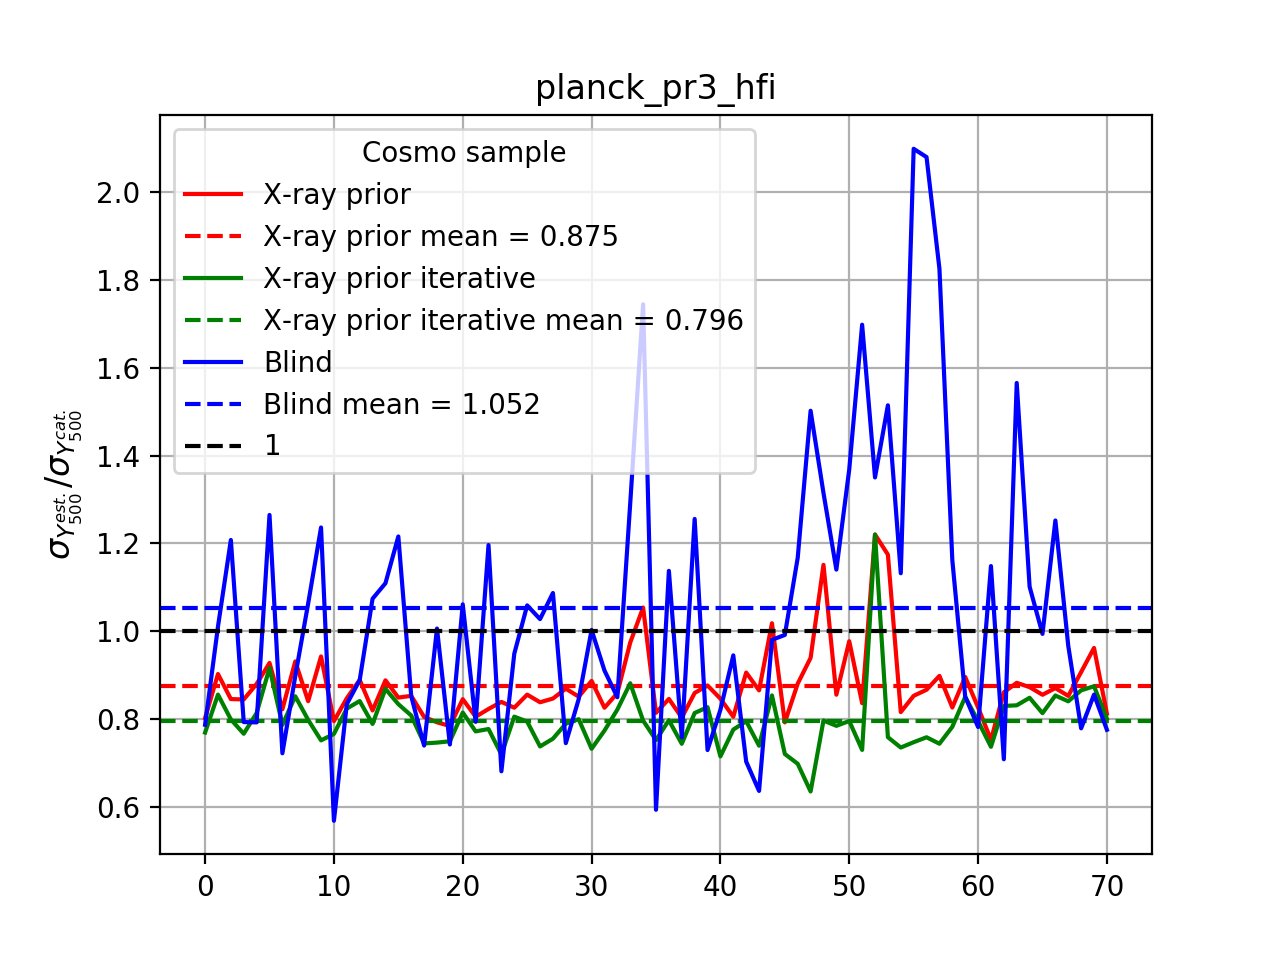

In [9]:
figure()
for ia,atype in enumerate(anatype[:3]):
        lbl=labels[atype]
        plot(fxsz_cat[atype]["YSZ_500_err"]/xsz_cat["YSZ_500_err"],label=lbl,c=clr[ia])
        mu=mean(np.array(fxsz_cat[atype]["YSZ_500_err"]/xsz_cat["YSZ_500_err"]))
        axhline(mu,label=lbl + " mean = "+ str(round(mu,3)),c=clr[ia],ls="--")

axhline(1.,ls="--",c="k",label="$1$")
legend(loc=0,title="Cosmo sample")
ylabel("$\sigma_{Y^{est.}_{500}}/\sigma_{Y^{cat.}_{500}}$",fontsize=12)
#ylim(0.75,1.25)
grid()
title(figstamp)
if save_results:
    figname=figpath + "compare_Y500_err.pdf"
    savefig(figname,bbox_inches="tight")

<IPython.core.display.Javascript object>


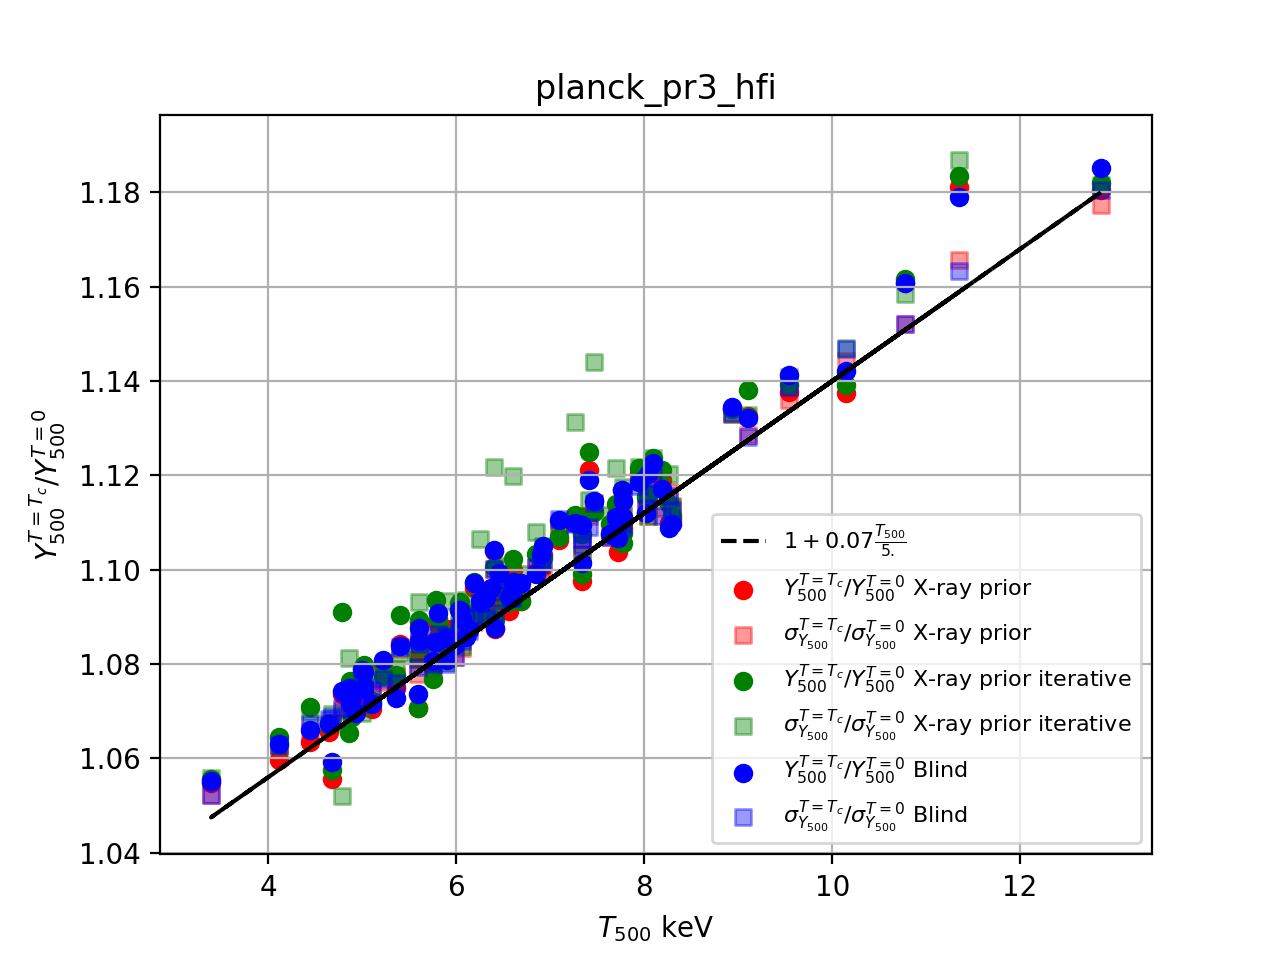

<IPython.core.display.Javascript object>


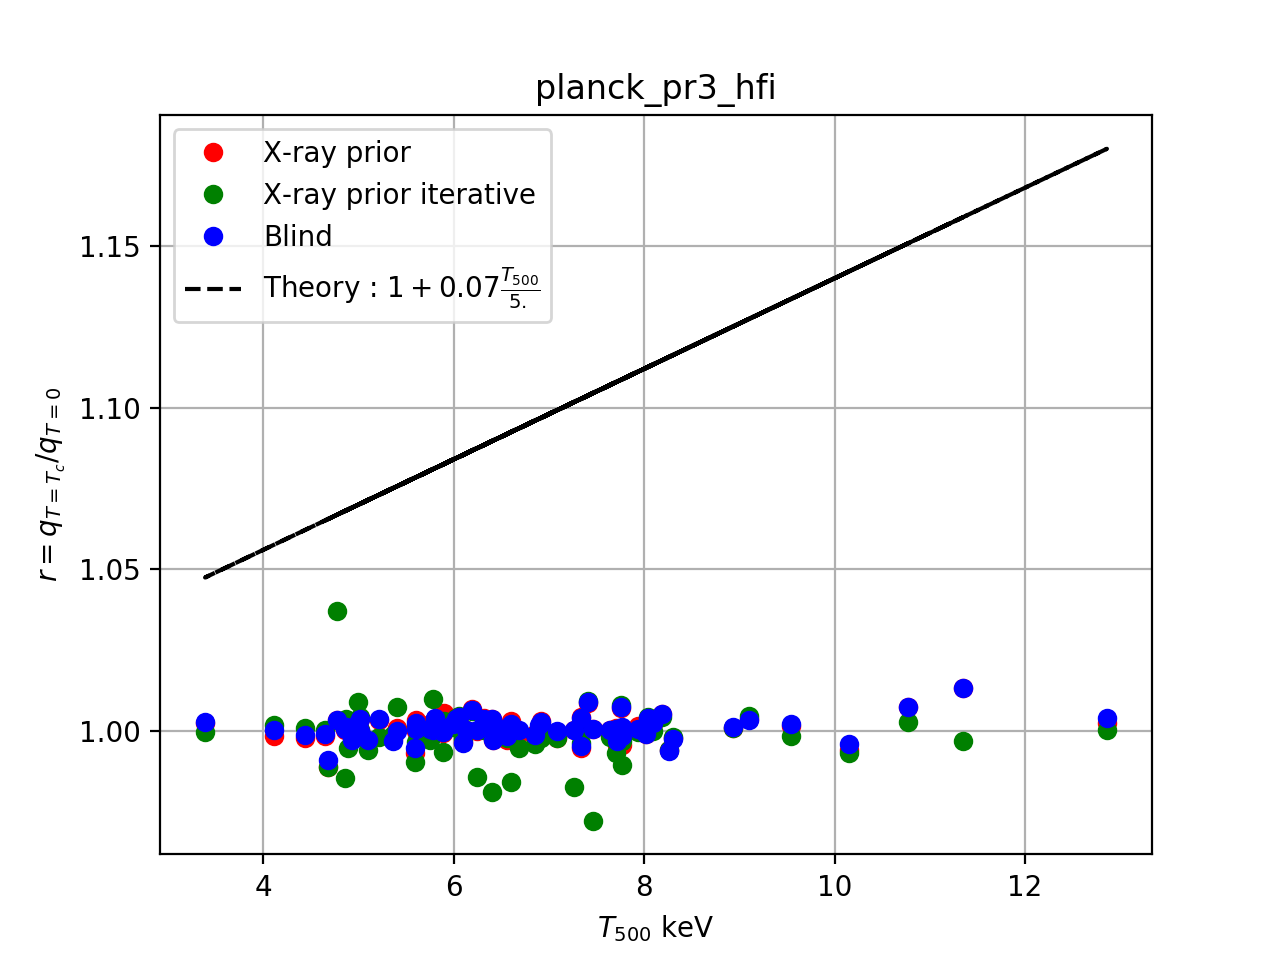

In [10]:
figure()
for ia, atype in enumerate(anatype):
    lbl="$Y^{T=T_c}_{500}/Y^{T=0}_{500}$ " + labels[atype]
    scatter(xsz_cat["T500"],fxsz_cat[atype]["YSZ_500_Tc"]/fxsz_cat[atype]["YSZ_500"],label=lbl,c=clr[ia])
    lbl="$\sigma^{T=T_c}_{Y_{500}}/\sigma^{T=0}_{Y_{500}}$ "  + labels[atype]
    scatter(xsz_cat["T500"],fxsz_cat[atype]["YSZ_500_err_Tc"]/fxsz_cat[atype]["YSZ_500_err"],label=lbl,c=clr[ia],marker="s",alpha=0.4)


plot(xsz_cat["T500"],1+0.07*xsz_cat["T500"]/5.,"k--",label=r"$1 + 0.07 \frac{T_{500}}{5.}$")
xlabel('$T_{500}$ keV')
ylabel('$Y^{T=T_c}_{500}/Y^{T=0}_{500}$')
grid()
legend(loc=0,fontsize=8)
title(figstamp)
if save_results:
    figname=figpath + "Y500_T0_vs_Y500_Tc.pdf"
    savefig(figname,bbox_inches="tight")


fn=lambda x,a: 1.+a*x/5.


figure()
for ia, atype in enumerate(anatype):
    qTT=fxsz_cat[atype]["YSZ_500_Tc"]/fxsz_cat[atype]["YSZ_500_err_Tc"]
    qT0=fxsz_cat[atype]["YSZ_500"]/fxsz_cat[atype]["YSZ_500_err"]
    lbl=labels[atype]
    plot(xsz_cat["T500"],qTT/qT0,"o",label=lbl,c=clr[ia])

slope=0.07
plot(xsz_cat["T500"],fn(xsz_cat["T500"],slope),"k--",label="Theory : " + "$1 + $" + str(round(slope,4)) + r"$\frac{T_{500}}{5.}$")
xlabel('$T_{500}$ keV')
ylabel('$r=q_{T=T_c}/q_{T=0}$')
grid()
legend(loc=0)
title(figstamp)
if save_results:
    figname=figpath + "SNR_qT0_qTT.pdf"
    savefig(figname,bbox_inches="tight")

## Deriving $Y^{SZ}_{500} - Y^X_{500}$ scalinng law

In [ ]:
# xdata=log10(xsz_cat["YX_500"]/1e-4)
# xerr=return_log_err(xsz_cat["YX_500"]/1e-4,xsz_cat["YX_500_err"]/1e-4)

# # Catalogue
# ydata=log10(xsz_cat["YSZ_500"])
# yerr=return_log_err(xsz_cat["YSZ_500"],xsz_cat["YSZ_500_err"])
# acat,bcat,erracat,errbcat,covab=bces.bcesp(xdata,xerr,ydata,yerr,np.zeros_like(xdata),100000)
# print acat[3],erracat[3],bcat[3],errbcat[3]


# # T=0
# ydata=log10(fxsz_cat["YSZ_500"])
# yerr=return_log_err(fxsz_cat["YSZ_500"],fxsz_cat["YSZ_500_err"])
# aT0,bT0,erraT0,errbT0,covab=bces.bcesp(xdata,xerr,ydata,yerr,np.zeros_like(xdata),100000)
# print aT0[3],erraT0[3],bT0[3],errbT0[3]

# # T=T_c
# ydata=log10(fxsz_cat["YSZ_500_Tc"])
# yerr=return_log_err(fxsz_cat["YSZ_500_Tc"],fxsz_cat["YSZ_500_err_Tc"])
# aTT,bTT,erraTT,errbTT,covab=bces.bcesp(xdata,xerr,ydata,yerr,np.zeros_like(xdata),100000)
# print aTT[3],erraTT[3],bTT[3],errbTT[3]

In [ ]:
# figure()
# errorbar(xsz_cat["YX_500"],xsz_cat["YSZ_500"],xerr=xsz_cat["YX_500_err"],yerr=xsz_cat["YSZ_500_err"],fmt='o',ms=5,label="Catalogue")
# errorbar(xsz_cat["YX_500"]+0.02*xsz_cat["YX_500"],fxsz_cat["YSZ_500"],xerr=xsz_cat["YX_500_err"],yerr=fxsz_cat["YSZ_500_err"],fmt='o',ms=5,label="Estimated $(T=0)$")
# tempx=linspace(5e-6,5e-3,1000)
# lbl="$A_{cat}$ = " + str(round(bcat[3],2)) + "$\pm$" + str(round(errbcat[3],3)) 
# lbl=lbl + " ; $B_{cat}$ = " +str(round(acat[3],2))  + "$\pm$" + str(round(erracat[3],3))
# plot(tempx,(10.**bcat[3])*(tempx/1e-4)**acat[3],label=lbl,zorder=1)

# lbl="$A_{T=0}$ = " + str(round(bT0[3],2)) + "$\pm$" + str(round(errbT0[3],3)) 
# lbl=lbl + " ; $B_{T=0}$ = " +str(round(aT0[3],2))  + "$\pm$" + str(round(erraT0[3],3))
# plot(tempx,(10.**bT0[3])*(tempx/1e-4)**aT0[3],label=lbl,zorder=3)
# ylim(5e-6,1e-3)
# xlim(5e-6,1e-3)
# loglog()
# legend(loc=0)
# ylabel("$Y^{SZ}_{500}$",fontsize=10)
# xlabel("$Y^X_{500}$",fontsize=10)
# grid(which="both",alpha=0.4)
# figname=figpath + "YSZ500_YX500_cat_vs_est.pdf"
# savefig(figname,bbox_inches="tight")

In [ ]:
# figure()
# errorbar(xsz_cat["YX_500"],fxsz_cat["YSZ_500"],xerr=xsz_cat["YX_500_err"],yerr=fxsz_cat["YSZ_500_err"],fmt='o',ms=5,label="Estimated $(T=0)$")
# errorbar(xsz_cat["YX_500"],fxsz_cat["YSZ_500_Tc"],xerr=xsz_cat["YX_500_err"],yerr=fxsz_cat["YSZ_500_err_Tc"],fmt='o',ms=5,label="Estimated $(T=T_c)$")
# tempx=linspace(5e-6,5e-3,1000)
# lbl="$A_{T=0}$ = " + str(round(bT0[3],2)) + "$\pm$" + str(round(errbT0[3],3)) 
# lbl=lbl + " ; $B_{T=0}$ = " +str(round(aT0[3],2))  + "$\pm$" + str(round(erraT0[3],3))
# plot(tempx,(10.**bT0[3])*(tempx/1e-4)**aT0[3],label=lbl,zorder=3)

# lbl="$A_{T=T_c}$ = " + str(round(bTT[3],2)) + "$\pm$" + str(round(errbTT[3],3)) 
# lbl=lbl + " ; $B_{T=T_c}$ = " +str(round(aTT[3],2))  + "$\pm$" + str(round(erraTT[3],3))
# plot(tempx,(10.**bTT[3])*(tempx/1e-4)**aTT[3],label=lbl,zorder=5)

# ylim(5e-6,1e-3)
# xlim(5e-6,1e-3)
# loglog()
# legend(loc=0)
# ylabel("$Y^{SZ}_{500}$",fontsize=10)
# xlabel("$Y^X_{500}$",fontsize=10)
# grid(which="both",alpha=0.4)
# figname=figpath + "YSZ500_YX500_T0_vs_TT.pdf"
# savefig(figname,bbox_inches="tight")

## Deriving $Y^{SZ}_{500} - M^X_{500}$ scalinng law

In [12]:
# # This produces numbers in row 2 of Table 2 from Planck early results XI (A&A 536 A11 2011)
# Ezgamma=cosmo_fn.Ez(xsz_cat["z"])**(-2./3.)
# This produces numbers in Table A.1 from Planck Collaboration: Cosmology from SZ cluster counts (2013)
Ezgamma=(cosmo_fn.Ez(xsz_cat["z"])**(-2./3.))/1e-4
Ezgamma=Ezgamma/xsz_cat["BIAS"]

xdata=log10(xsz_cat["M500"]/6.)
xerr=ymsr.return_log_err(xsz_cat["M500"]/6.,xsz_cat["M500_err"]/6.)

# Catalogue
ydata=log10(xsz_cat["YSZ_500"]*Ezgamma)
yerr=ymsr.return_log_err(xsz_cat["YSZ_500"]*Ezgamma,xsz_cat["YSZ_500_err"]*Ezgamma)
acat,bcat,erracat,errbcat,covab=bces.bcesp(xdata,xerr,ydata,yerr,np.zeros_like(xdata),100000)
fitcat=np.array([acat[3],erracat[3],bcat[3],errbcat[3]])
print fitcat

fitT0={}
for atype in anatype:
    ydata=log10(fxsz_cat[atype]["YSZ_500"]*Ezgamma) 
    yerr=ymsr.return_log_err(fxsz_cat[atype]["YSZ_500"]*Ezgamma,fxsz_cat[atype]["YSZ_500_err"]*Ezgamma)
    a,b,erra,errb,covab=bces.bcesp(xdata,xerr,ydata,yerr,np.zeros_like(xdata),100000)
    fitT0[atype]=np.array([a[3],erra[3],b[3],errb[3]])
    print atype,fitT0[atype]
    
fitTT={}
for atype in anatype:
    ydata=log10(fxsz_cat[atype]["YSZ_500_Tc"]*Ezgamma) 
    yerr=ymsr.return_log_err(fxsz_cat[atype]["YSZ_500_Tc"]*Ezgamma,fxsz_cat[atype]["YSZ_500_err_Tc"]*Ezgamma)
    a,b,erra,errb,covab=bces.bcesp(xdata,xerr,ydata,yerr,np.zeros_like(xdata),100000)
    fitTT[atype]=np.array([a[3],erra[3],b[3],errb[3]])
    print atype,fitTT[atype]
    
fitTT={}
for atype in anatype:
    ydata=log10(fxsz_cat[atype]["YSZ_500_Tc"]*Ezgamma) 
    yerr=ymsr.return_log_err(fxsz_cat[atype]["YSZ_500_Tc"]*Ezgamma,fxsz_cat[atype]["YSZ_500_err_Tc"]*Ezgamma)
    a,b,erra,errb,covab=bces.bcesp(xdata,xerr,ydata,yerr,np.zeros_like(xdata),100000)
    fitTT[atype]=np.array([a[3],erra[3],b[3],errb[3]])
    print atype,fitTT[atype]

BCES, 100000 trials... 
15.818015 s
[ 1.78879048  0.0640462  -0.18557619  0.01045569]
BCES, 100000 trials... 
13.737696 s
x [ 1.83468876  0.0765054  -0.18925012  0.01177256]
BCES, 100000 trials... 
15.217032 s
xi [ 1.78757128  0.07486744 -0.17541285  0.01167884]
BCES, 100000 trials... 
15.115827 s
b [ 1.7484028   0.1315694  -0.12076889  0.01812679]


NameError: name 'return_log_err' is not defined

<IPython.core.display.Javascript object>


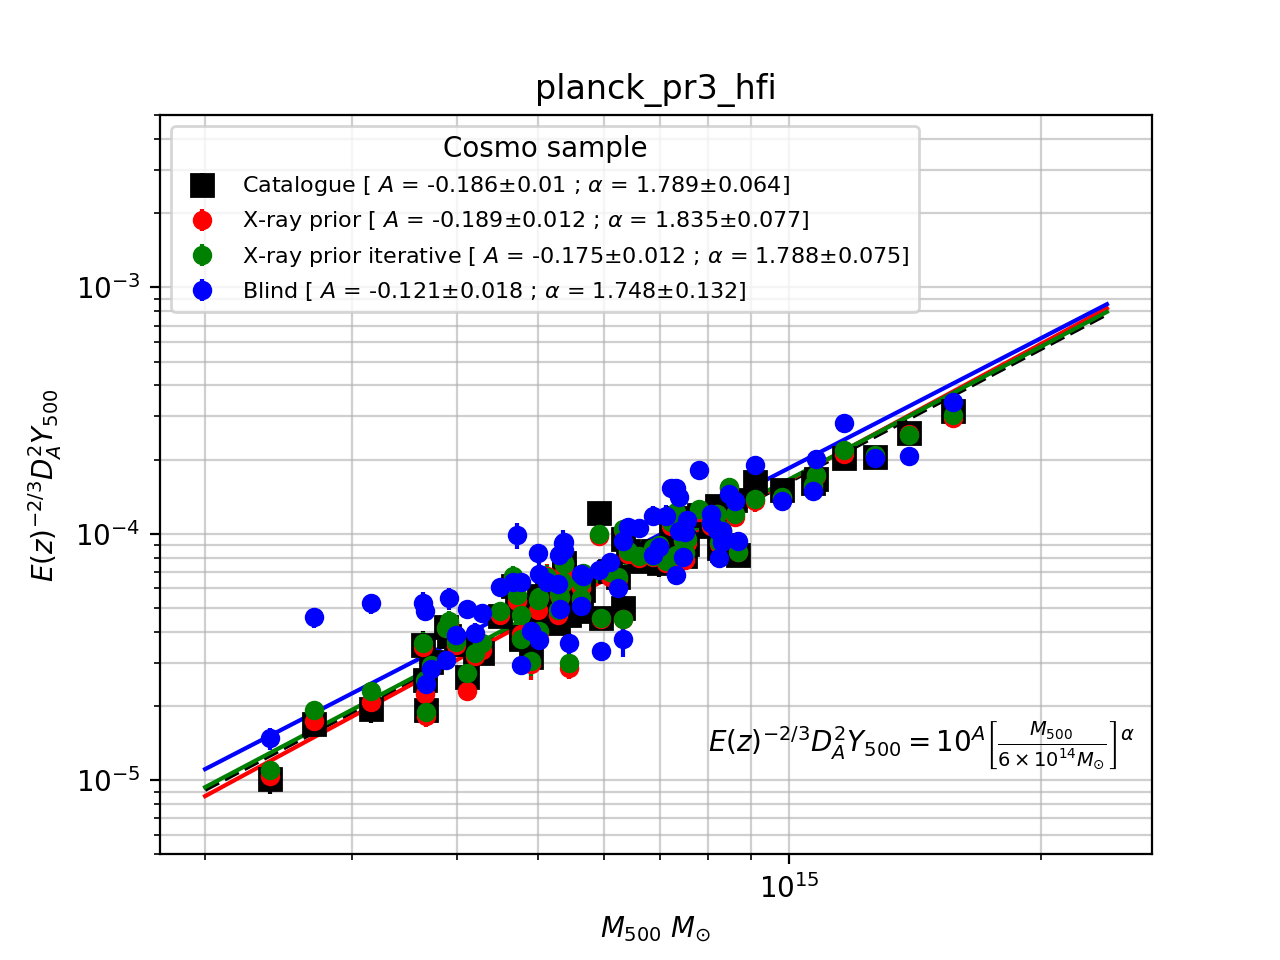

In [14]:
numdec=3
M500=linspace(2,24,1000)
norm=1e-4
figure()

lbl="Catalogue"
lbl=lbl+r" [ $A$ = " + str(round(fitcat[2],numdec)) + r"$\pm$" + str(round(fitcat[3],numdec)) 
lbl=lbl + r" ; $\alpha$ = " +str(round(fitcat[0],numdec))  + r"$\pm$" + str(round(fitcat[1],numdec)) + "]" 
errorbar(xsz_cat["M500"]*1e14,Ezgamma*xsz_cat["YSZ_500"]*norm,yerr=xsz_cat["YSZ_500_err"]*Ezgamma*norm,fmt="s",c="k",markersize=8,label=lbl)
plot(M500*1e14,(10.**fitcat[2])*((M500/6.)**fitcat[0])*norm,"k--")

for ia,atype in enumerate(anatype[:3]):
    lbl=labels[atype]
    lbl=lbl + r" [ $A$ = " + str(round(fitT0[atype][2],numdec)) + r"$\pm$" + str(round(fitT0[atype][3],numdec)) 
    lbl=lbl + r" ; $\alpha$ = " +str(round(fitT0[atype][0],numdec))  + r"$\pm$" + str(round(fitT0[atype][1],numdec)) + "]" 
    errorbar(xsz_cat["M500"]*1e14,Ezgamma*fxsz_cat[atype]["YSZ_500"]*norm,yerr=fxsz_cat[atype]["YSZ_500_err"]*Ezgamma*norm,fmt="o",c=clr[ia],label=lbl)
    plot(M500*1e14,(10.**fitT0[atype][2])*((M500/6.)**fitT0[atype][0])*norm,c=clr[ia])

ylabel(r"$E(z)^{-2/3} D^2_A Y_{500}$")
xlabel(r"$M_{500}$" + " " + "$M_{\odot}$")
lbl="Cosmo sample"
legend(loc=0,title=lbl,fontsize=8)
lbl=r"$E(z)^{-2/3} D^2_A Y_{500} = 10^A \left[ \frac{M_{500}}{6 \times 10^{14} M_{\odot}}\right]^\alpha$"
text(8e14,1.3e-5,lbl)
ylim(5e-6,5e-3)
title(figstamp)
loglog()
grid(which="both",alpha=0.6)
if save_results:
    figname=figpath + "Y500_vs_M500_compare_with_cat.pdf"
    savefig(figname,bbox_inches="tight")

<IPython.core.display.Javascript object>


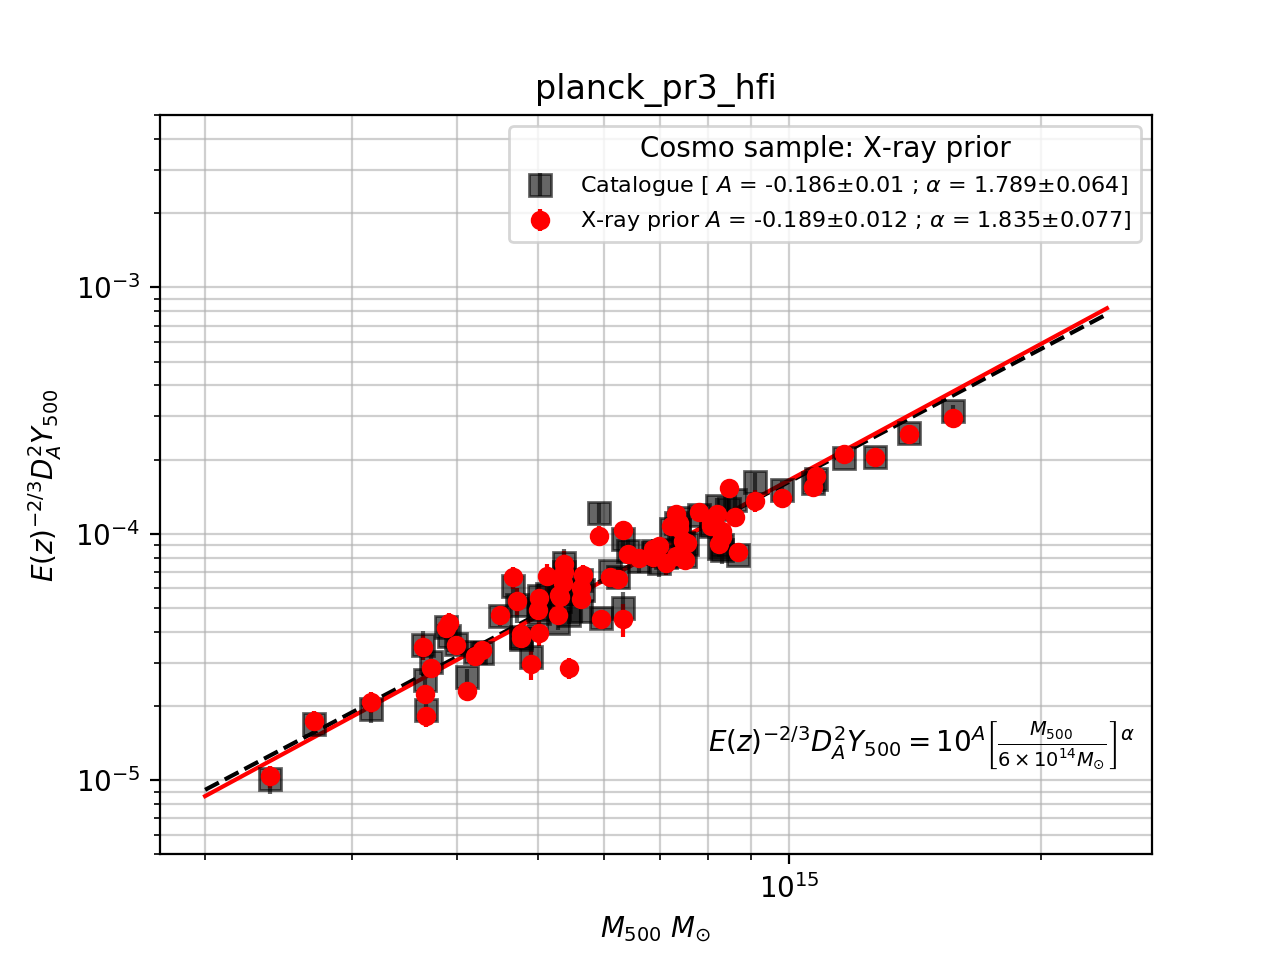

<IPython.core.display.Javascript object>


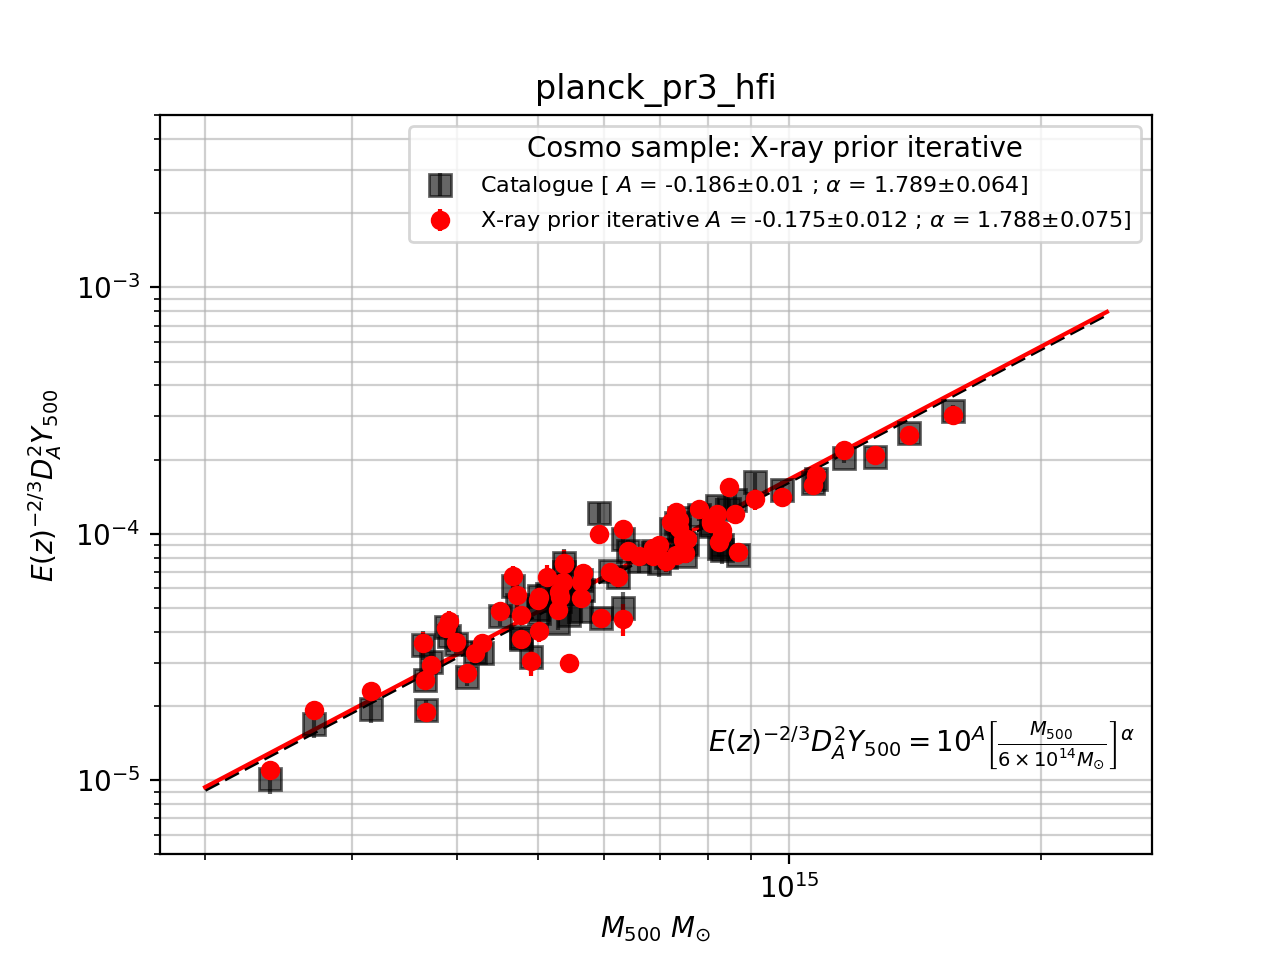

<IPython.core.display.Javascript object>


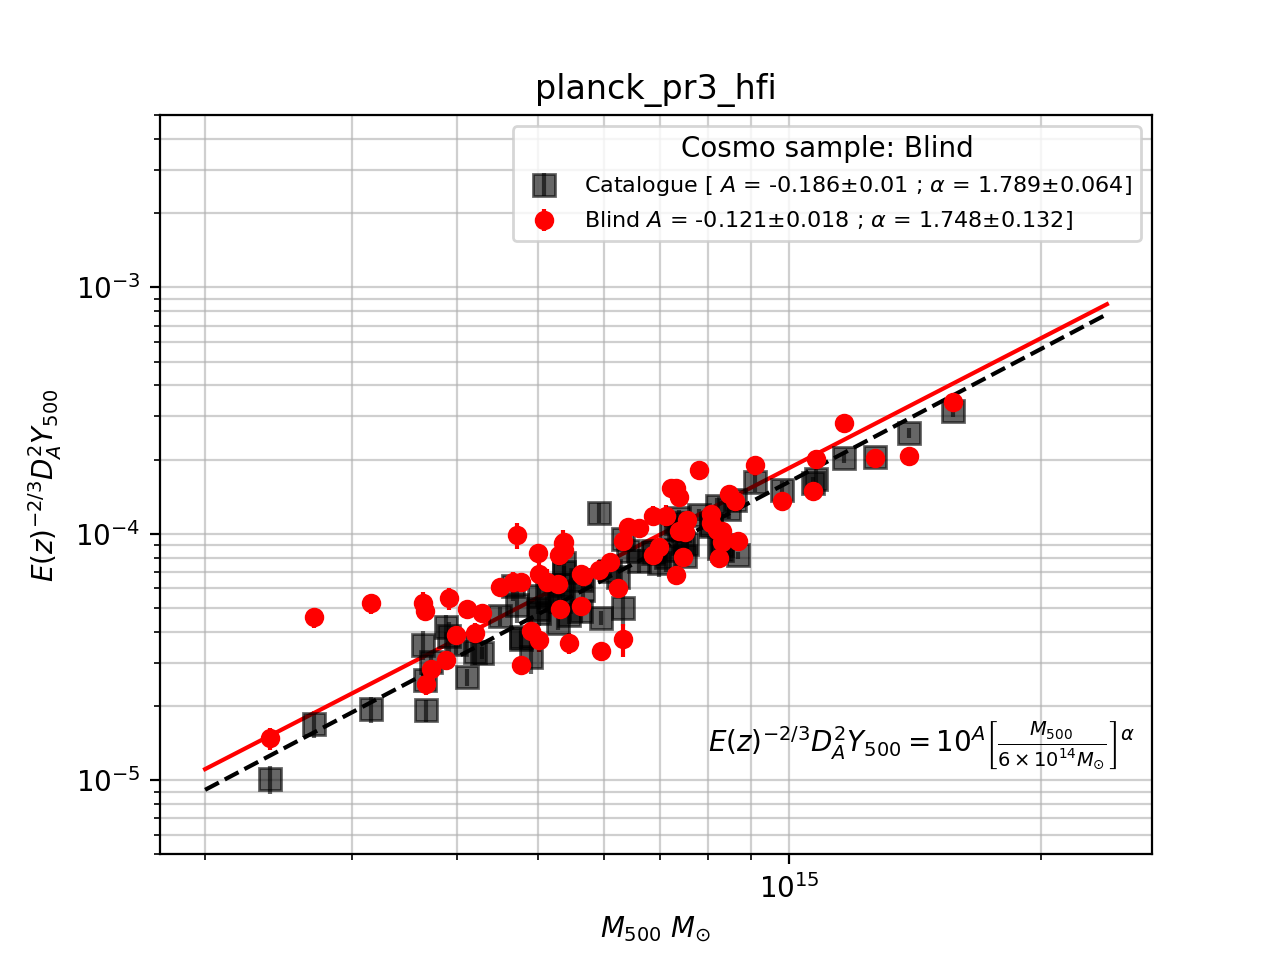

In [15]:
for ia,atype in enumerate(anatype[:3]):  
    figure()
    lbl="Catalogue"
    lbl=lbl+r" [ $A$ = " + str(round(fitcat[2],numdec)) + r"$\pm$" + str(round(fitcat[3],numdec)) 
    lbl=lbl + r" ; $\alpha$ = " +str(round(fitcat[0],numdec))  + r"$\pm$" + str(round(fitcat[1],numdec)) + "]" 
    errorbar(xsz_cat["M500"]*1e14,Ezgamma*xsz_cat["YSZ_500"]*norm,yerr=xsz_cat["YSZ_500_err"]*Ezgamma*norm,fmt="s",c="k",markersize=8,label=lbl,alpha=0.6)
    plot(M500*1e14,(10.**fitcat[2])*((M500/6.)**fitcat[0])*norm,"k--")
    lbl=labels[atype]
    lbl=lbl + r" $A$ = " + str(round(fitT0[atype][2],numdec)) + r"$\pm$" + str(round(fitT0[atype][3],numdec)) 
    lbl=lbl + r" ; $\alpha$ = " +str(round(fitT0[atype][0],numdec))  + r"$\pm$" + str(round(fitT0[atype][1],numdec)) + "]" 
    errorbar(xsz_cat["M500"]*1e14,Ezgamma*fxsz_cat[atype]["YSZ_500"]*norm,yerr=fxsz_cat[atype]["YSZ_500_err"]*Ezgamma*norm,fmt="o",c="r",label=lbl)
    plot(M500*1e14,(10.**fitT0[atype][2])*((M500/6.)**fitT0[atype][0])*norm,c="r")
    
    ylabel(r"$E(z)^{-2/3} D^2_A Y_{500}$")
    xlabel(r"$M_{500}$" + " " + "$M_{\odot}$")
    lbl=r"$E(z)^{-2/3} D^2_A Y_{500} = 10^A \left[ \frac{M_{500}}{6 \times 10^{14} M_{\odot}}\right]^\alpha$"
    text(8e14,1.3e-5,lbl)
    legend(loc=0,title="Cosmo sample: " + labels[atype],fontsize=8)
    ylim(5e-6,5e-3)
    title( figstamp)
    loglog()
    grid(which="both",alpha=0.6)
    if save_results:
        figname=figpath + "Y500_vs_M500_compare_with_cat_" + atype + ".pdf"
        savefig(figname,bbox_inches="tight")

<IPython.core.display.Javascript object>


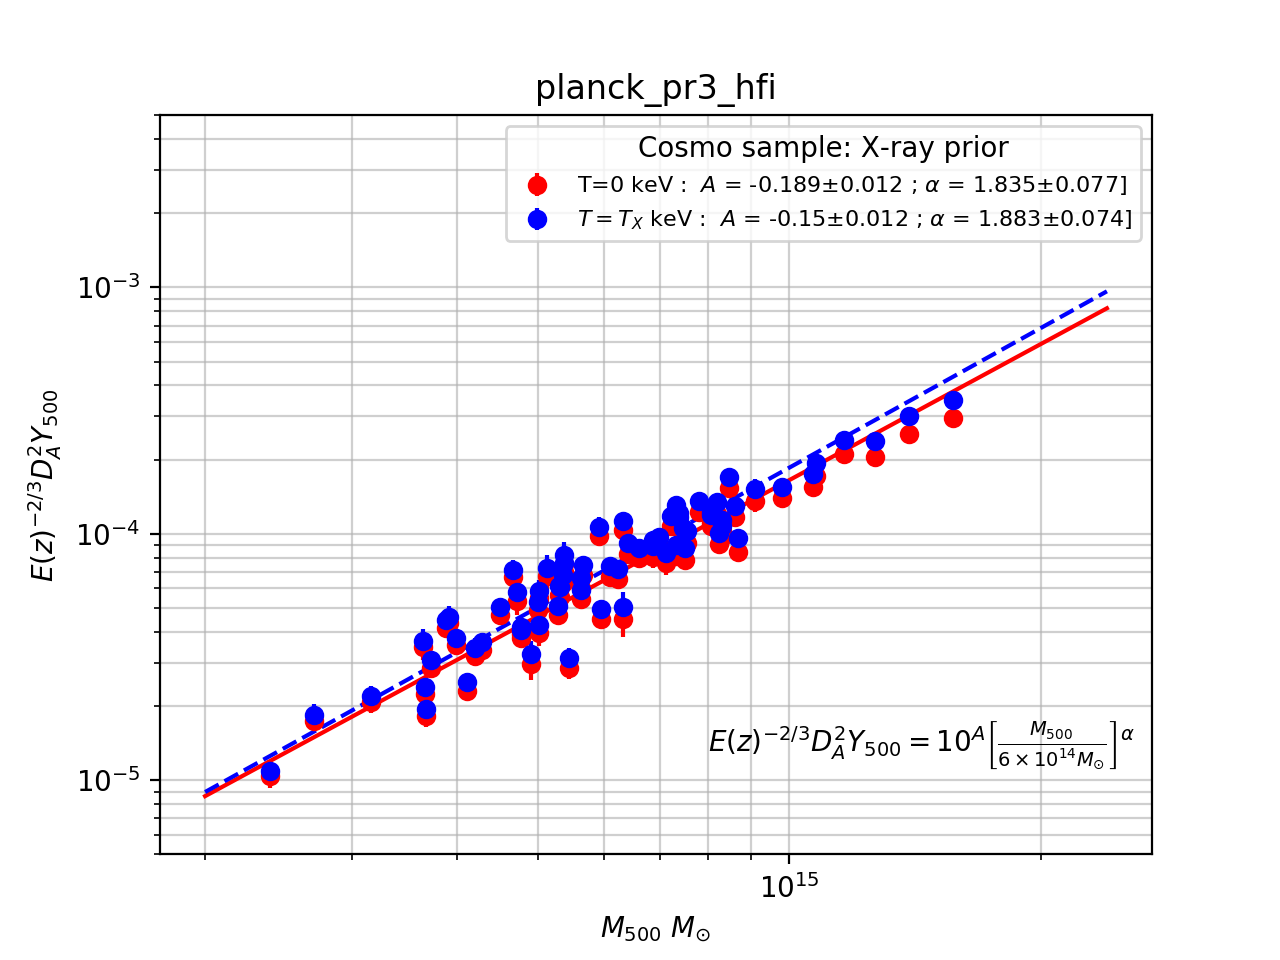

<IPython.core.display.Javascript object>


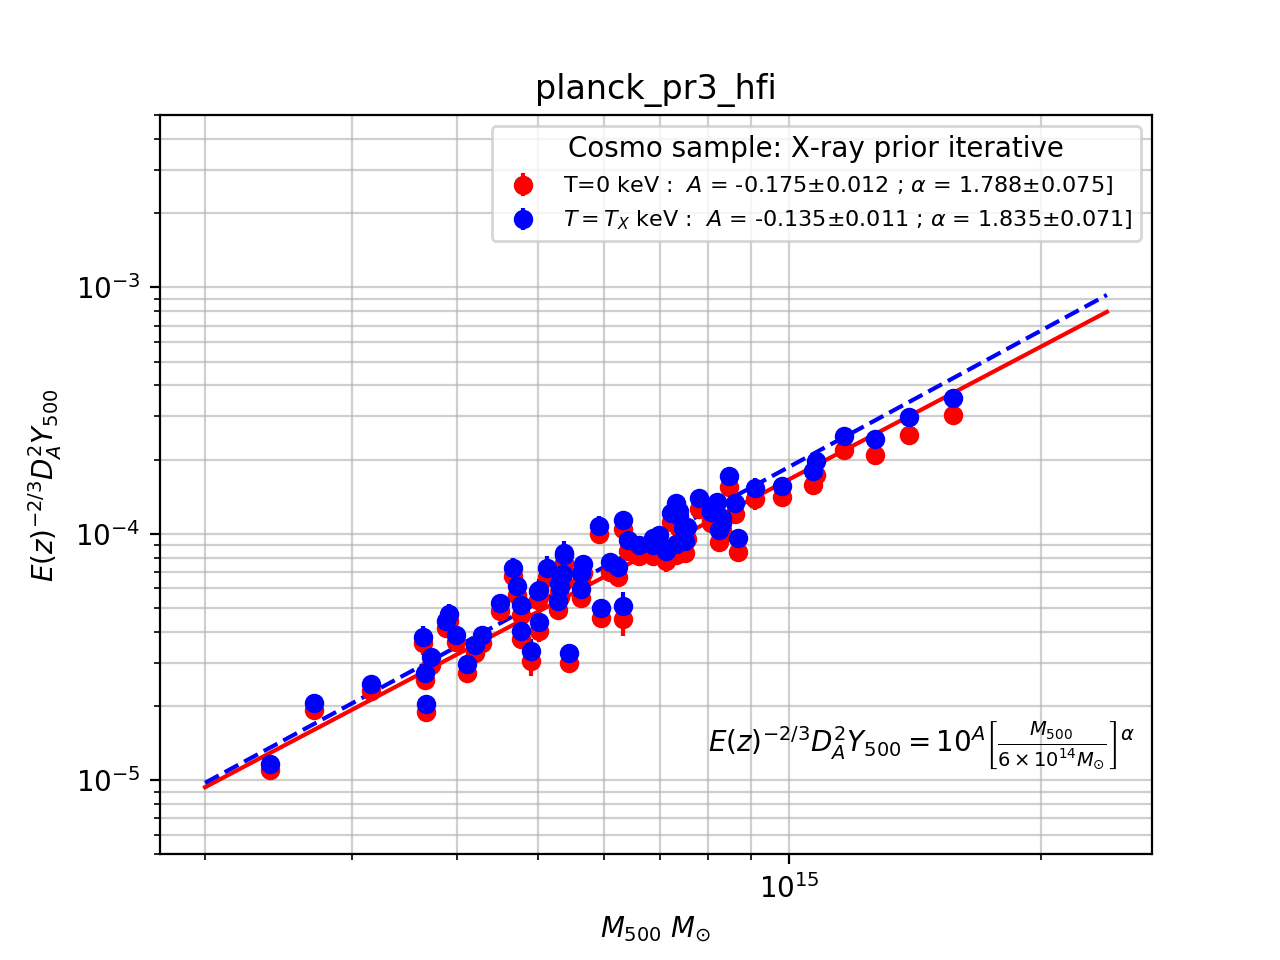

<IPython.core.display.Javascript object>


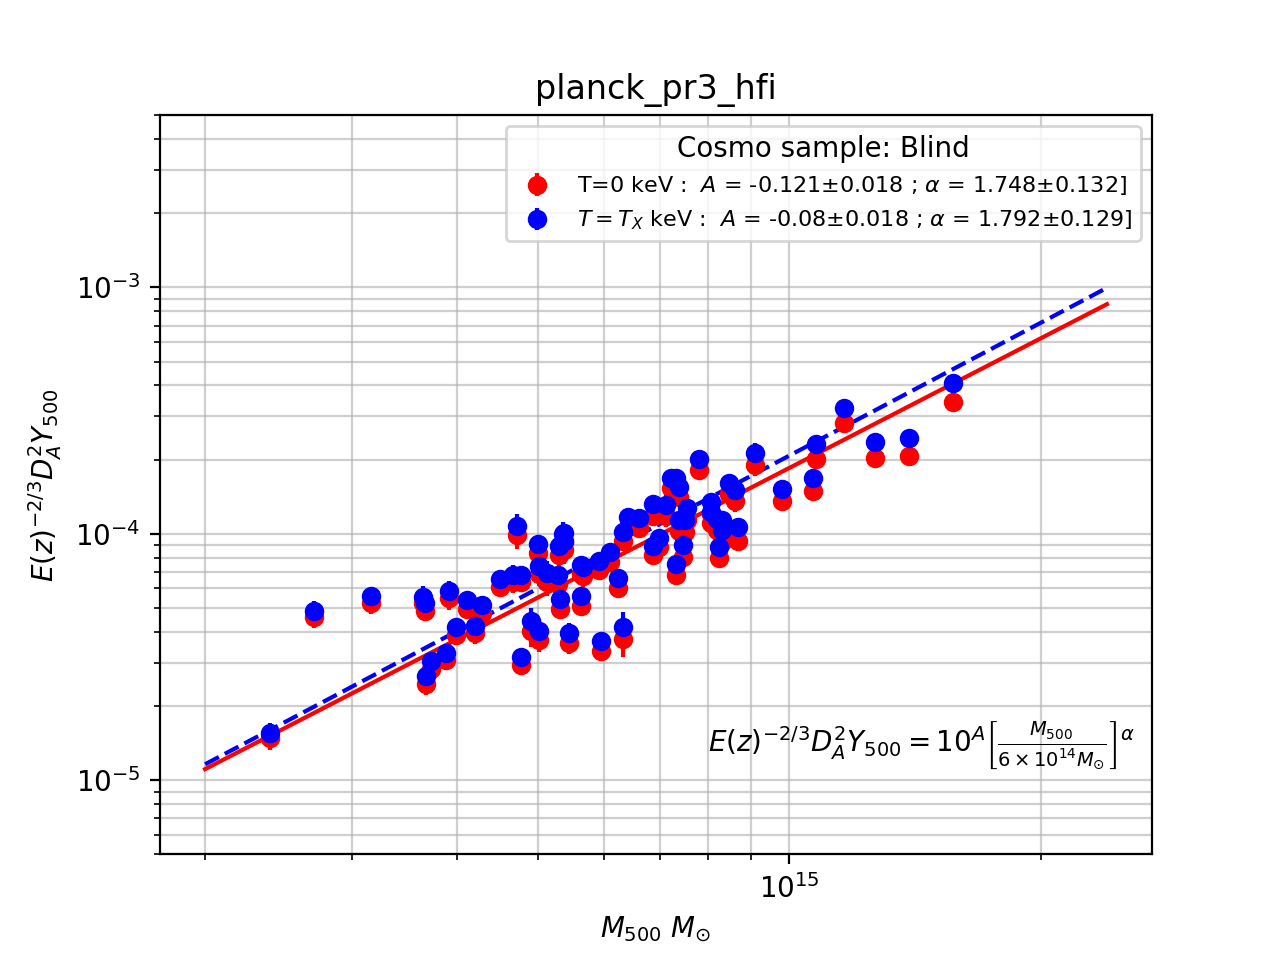

In [16]:
for ia,atype in enumerate(anatype[:3]):  
    figure()
    lbl="T=0 keV : "
    lbl=lbl + r" $A$ = " + str(round(fitT0[atype][2],numdec)) + r"$\pm$" + str(round(fitT0[atype][3],numdec)) 
    lbl=lbl + r" ; $\alpha$ = " +str(round(fitT0[atype][0],numdec))  + r"$\pm$" + str(round(fitT0[atype][1],numdec)) + "]" 
    errorbar(xsz_cat["M500"]*1e14,Ezgamma*fxsz_cat[atype]["YSZ_500"]*norm,yerr=fxsz_cat[atype]["YSZ_500_err"]*Ezgamma*norm,fmt="o",c="r",label=lbl)
    plot(M500*1e14,(10.**fitT0[atype][2])*((M500/6.)**fitT0[atype][0])*norm,c="r")
    lbl="$T=T_X$ keV : "
    lbl=lbl + r" $A$ = " + str(round(fitTT[atype][2],numdec)) + r"$\pm$" + str(round(fitTT[atype][3],numdec)) 
    lbl=lbl + r" ; $\alpha$ = " +str(round(fitTT[atype][0],numdec))  + r"$\pm$" + str(round(fitTT[atype][1],numdec)) + "]" 
    errorbar(xsz_cat["M500"]*1e14,Ezgamma*fxsz_cat[atype]["YSZ_500_Tc"]*norm,yerr=fxsz_cat[atype]["YSZ_500_err_Tc"]*Ezgamma*norm,fmt="o",c="b",label=lbl)
    plot(M500*1e14,(10.**fitTT[atype][2])*((M500/6.)**fitTT[atype][0])*norm,"b--")

    ylabel(r"$E(z)^{-2/3} D^2_A Y_{500}$")
    xlabel(r"$M_{500}$" + " " + "$M_{\odot}$")
    lbl=r"$E(z)^{-2/3} D^2_A Y_{500} = 10^A \left[ \frac{M_{500}}{6 \times 10^{14} M_{\odot}}\right]^\alpha$"
    text(8e14,1.3e-5,lbl)
    legend(loc=0,title="Cosmo sample: " + labels[atype],fontsize=8)
    ylim(5e-6,5e-3)
    title(figstamp)
    loglog()
    grid(which="both",alpha=0.6)
    if save_results:
        figname=figpath + "Y500_vs_M500_rSZ_correction_" + atype + ".pdf"
        savefig(figname,bbox_inches="tight")